In [1]:
import pandas as pd
import torch

In [2]:
batch_size = 8
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
train_df = pd.read_csv('Q3_train.csv')
test_df = pd.read_csv('Q3_test.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
label_to_char = {
    i-65: chr(i) for i in range(65,91)
}
char_to_label = {
    v:k for k, v in label_to_char.items()
}
label_to_char
char_to_label

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [5]:
import torch
from torch.utils.data import Dataset

class PandasDataset(Dataset):
  def __init__(self, df):
    self.x = df.drop('label', axis=1).values
    self.y = df['label'].values
    self.x = torch.tensor(self.x,dtype=torch.float32)
    self.y = torch.tensor(self.y,dtype=int)
 
  def __len__(self):
    return len(self.x)
   
  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]


In [6]:
train_dataset = PandasDataset(train_df)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = PandasDataset(test_df)

T


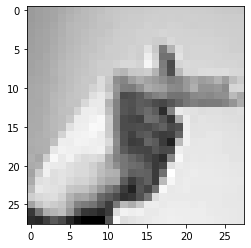

R


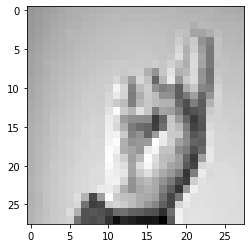

E


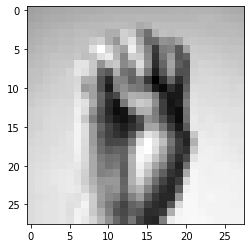

R


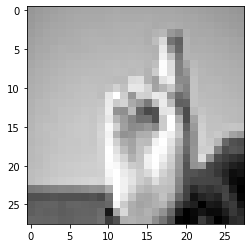

I


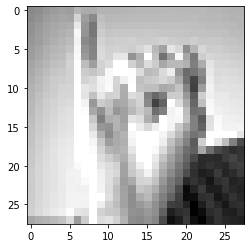

P


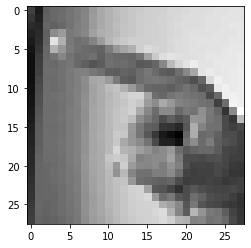

B


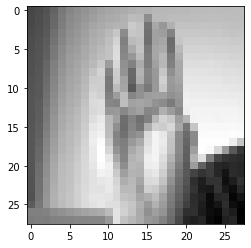

C


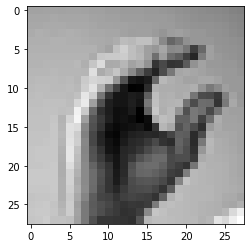

K


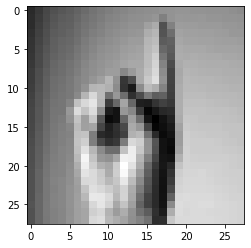

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
sample = random.sample(range(len(train_dataset)), 9)
for i in sample:
    x, y = train_dataset[i]
    label = label_to_char[y.item()]
    print(label)
    plt.imshow(x.view(28,28), cmap='gray')
    plt.show()

In [8]:
from torch.utils.data import DataLoader
from tqdm import tqdm

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [42]:
from torch import nn

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)
        self.l5 = nn.Linear(64, 32)
        self.l6 = nn.Linear(32, 26)

        # self.act = nn.Tanh()
        self.act = nn.ReLU()
        self.loss = nn.CrossEntropyLoss(reduction='mean')
    

    def forward(self, xb, yb=None):
        xb = self.act(self.l1(xb))
        xb = self.act(self.l2(xb))
        xb = self.act(self.l3(xb))
        xb = self.act(self.l4(xb))
        xb = self.act(self.l5(xb))
        logits = self.l6(xb)

        if not yb is None:
            loss = self.loss(logits, yb)
        else:
            loss = None
        return logits, loss

In [16]:
def evaluate(model, dataloader):
    total_loss = 0 
    correct_guess = 0
    for xb, yb in tqdm(dataloader):
        xb = xb.to(device)
        yb = yb.to(device)
        with torch.no_grad():
            logits, loss = model(xb, yb)
            preds = logits.argmax(dim=1)
            correct_guess += (preds == yb).sum().item()
            total_loss += loss.item()

    accuracy = correct_guess / len(test_dataset)
    print('val accuracy: ', accuracy)
    print('val loss:', total_loss)
    return total_loss, accuracy

In [22]:
from tqdm import tqdm
from torch.optim import SGD

def train_model(model, train_dataloader, test_dataloader, optimizer, epochs=20):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        print('------------------------------ epoch: ', epoch)
        train_loss = 0
        correct_guess = 0
        for xb, yb in tqdm(train_dataloader):
            xb = xb.to(device)
            yb = yb.to(device)
            logits, loss = model(xb, yb)
            # print(loss)
            if loss.isnan():
                print(logits.argmax(dim=1))
                print(yb)
                print('----------------')
                raise Exception('a')
                # break
            
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            # preds = logits.argmax(dim=1)
            # correct_guess += (preds == yb).sum().item()
        
        # print('train accuracy: ', correct_guess / len(train_dataset))
        print('train loss:', train_loss)
        val_loss, val_acc = evaluate(model, val_dataloader)
        val_losses.append(val_loss)
        train_losses.append(train_loss)
    return train_losses, val_losses

In [45]:
model_sgd = SimpleModel().to(device)
optimizer_sgd = SGD(model_sgd.parameters(), lr=0.01)
train_losses_sgd, val_losses_sgd = train_model(model_sgd, train_dataloader, val_dataloader, optimizer_sgd)

------------------------------ epoch:  0


100%|██████████| 2746/2746 [00:11<00:00, 233.29it/s]


train loss: 5795.178246557713


100%|██████████| 687/687 [00:00<00:00, 1105.17it/s]


val accuracy:  0.39988845510317905
val loss: 910.1505000591278
------------------------------ epoch:  1


100%|██████████| 2746/2746 [00:10<00:00, 251.31it/s]


train loss: 2860.981862194836


100%|██████████| 687/687 [00:00<00:00, 1066.57it/s]


val accuracy:  0.4677914110429448
val loss: 912.1153196319938
------------------------------ epoch:  2


100%|██████████| 2746/2746 [00:11<00:00, 245.43it/s]


train loss: 1807.2304733553901


100%|██████████| 687/687 [00:00<00:00, 1063.14it/s]


val accuracy:  0.6146123814835471
val loss: 365.72969655133784
------------------------------ epoch:  3


100%|██████████| 2746/2746 [00:11<00:00, 245.14it/s]


train loss: 1223.719565911335


100%|██████████| 687/687 [00:00<00:00, 1072.04it/s]


val accuracy:  0.672755158951478
val loss: 227.5642631284427
------------------------------ epoch:  4


100%|██████████| 2746/2746 [00:11<00:00, 245.63it/s]


train loss: 853.9624843382044


100%|██████████| 687/687 [00:00<00:00, 1093.01it/s]


val accuracy:  0.7289459007250418
val loss: 95.0341138306685
------------------------------ epoch:  5


100%|██████████| 2746/2746 [00:11<00:00, 246.64it/s]


train loss: 600.2368824679979


100%|██████████| 687/687 [00:00<00:00, 1062.67it/s]


val accuracy:  0.7327105409927496
val loss: 97.89943593905355
------------------------------ epoch:  6


100%|██████████| 2746/2746 [00:10<00:00, 251.20it/s]


train loss: 415.453574626546


100%|██████████| 687/687 [00:00<00:00, 1054.26it/s]


val accuracy:  0.7211377579475738
val loss: 166.7510024839246
------------------------------ epoch:  7


100%|██████████| 2746/2746 [00:11<00:00, 249.13it/s]


train loss: 239.93815380805552


100%|██████████| 687/687 [00:00<00:00, 1129.57it/s]


val accuracy:  0.723786949247072
val loss: 121.17942318352925
------------------------------ epoch:  8


100%|██████████| 2746/2746 [00:10<00:00, 251.23it/s]


train loss: 105.50881194689767


100%|██████████| 687/687 [00:00<00:00, 1099.48it/s]


val accuracy:  0.7649191299498048
val loss: 1.5978085730140066
------------------------------ epoch:  9


100%|██████████| 2746/2746 [00:10<00:00, 253.79it/s]


train loss: 35.10623359425837


100%|██████████| 687/687 [00:00<00:00, 1096.93it/s]


val accuracy:  0.7656162855549359
val loss: 0.022526658633514884
------------------------------ epoch:  10


100%|██████████| 2746/2746 [00:10<00:00, 254.27it/s]


train loss: 0.13225073317982616


100%|██████████| 687/687 [00:00<00:00, 1078.93it/s]


val accuracy:  0.7656162855549359
val loss: 0.013136120052745781
------------------------------ epoch:  11


100%|██████████| 2746/2746 [00:10<00:00, 252.44it/s]


train loss: 0.026981517790194864


100%|██████████| 687/687 [00:00<00:00, 1113.47it/s]


val accuracy:  0.7656162855549359
val loss: 0.009571174385865966
------------------------------ epoch:  12


100%|██████████| 2746/2746 [00:10<00:00, 252.76it/s]


train loss: 0.021903072964543746


100%|██████████| 687/687 [00:00<00:00, 1094.11it/s]


val accuracy:  0.7656162855549359
val loss: 0.007742393144646087
------------------------------ epoch:  13


100%|██████████| 2746/2746 [00:10<00:00, 253.11it/s]


train loss: 0.018895522719159175


100%|██████████| 687/687 [00:00<00:00, 1093.37it/s]


val accuracy:  0.7656162855549359
val loss: 0.00691939832710009
------------------------------ epoch:  14


100%|██████████| 2746/2746 [00:10<00:00, 254.35it/s]


train loss: 0.016803032727530365


100%|██████████| 687/687 [00:00<00:00, 1074.15it/s]


val accuracy:  0.7656162855549359
val loss: 0.006237115791647874
------------------------------ epoch:  15


100%|██████████| 2746/2746 [00:10<00:00, 253.86it/s]


train loss: 0.01526922083418114


100%|██████████| 687/687 [00:00<00:00, 1133.76it/s]


val accuracy:  0.7656162855549359
val loss: 0.005655208217422825
------------------------------ epoch:  16


100%|██████████| 2746/2746 [00:11<00:00, 232.69it/s]


train loss: 0.014070307640992041


100%|██████████| 687/687 [00:00<00:00, 1059.08it/s]


val accuracy:  0.7656162855549359
val loss: 0.005309732288143465
------------------------------ epoch:  17


100%|██████████| 2746/2746 [00:11<00:00, 245.97it/s]


train loss: 0.013091137322122748


100%|██████████| 687/687 [00:00<00:00, 1088.22it/s]


val accuracy:  0.7656162855549359
val loss: 0.004959336281347149
------------------------------ epoch:  18


100%|██████████| 2746/2746 [00:10<00:00, 256.42it/s]


train loss: 0.012245235020407641


100%|██████████| 687/687 [00:00<00:00, 1076.92it/s]


val accuracy:  0.7656162855549359
val loss: 0.004728819657915828
------------------------------ epoch:  19


100%|██████████| 2746/2746 [00:10<00:00, 260.25it/s]


train loss: 0.011584368823401192


100%|██████████| 687/687 [00:00<00:00, 1067.64it/s]

val accuracy:  0.7656162855549359
val loss: 0.004427260280134959


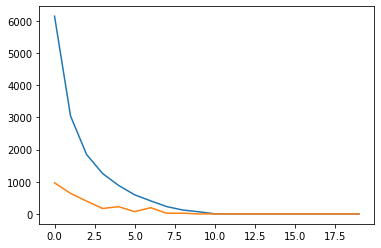

In [24]:
plt.plot(train_losses_sgd)
plt.plot(val_losses_sgd)
plt.show()

In [29]:
model_adam = SimpleModel().to(device)
optimizer_adam = SGD(model_adam.parameters(), lr=0.001)
train_losses_adam, val_losses_adam = train_model(model_adam, train_dataloader, val_dataloader, optimizer_adam, epochs=40)

------------------------------ epoch:  0


100%|██████████| 2746/2746 [00:11<00:00, 236.34it/s]


train loss: 8056.936750292778


100%|██████████| 687/687 [00:00<00:00, 1091.83it/s]


val accuracy:  0.1953430005577245
val loss: 1801.788604259491
------------------------------ epoch:  1


100%|██████████| 2746/2746 [00:12<00:00, 221.81it/s]


train loss: 6263.988339066505


100%|██████████| 687/687 [00:00<00:00, 1072.83it/s]


val accuracy:  0.31469604015616287
val loss: 1344.2445030212402
------------------------------ epoch:  2


100%|██████████| 2746/2746 [00:14<00:00, 187.93it/s]


train loss: 4727.925185441971


100%|██████████| 687/687 [00:01<00:00, 536.59it/s]


val accuracy:  0.41899051868377024
val loss: 1056.726744055748
------------------------------ epoch:  3


100%|██████████| 2746/2746 [00:13<00:00, 208.92it/s]


train loss: 3827.187351077795


100%|██████████| 687/687 [00:00<00:00, 1093.42it/s]


val accuracy:  0.4867540435025098
val loss: 875.600493311882
------------------------------ epoch:  4


100%|██████████| 2746/2746 [00:11<00:00, 241.79it/s]


train loss: 3190.300232768059


100%|██████████| 687/687 [00:01<00:00, 544.27it/s]


val accuracy:  0.5179866146123815
val loss: 761.3404778540134
------------------------------ epoch:  5


100%|██████████| 2746/2746 [00:11<00:00, 236.13it/s]


train loss: 2698.519455164671


100%|██████████| 687/687 [00:00<00:00, 1105.58it/s]


val accuracy:  0.5296988287785834
val loss: 699.8123186826706
------------------------------ epoch:  6


100%|██████████| 2746/2746 [00:11<00:00, 239.19it/s]


train loss: 2319.962465532124


100%|██████████| 687/687 [00:00<00:00, 1064.62it/s]


val accuracy:  0.5614891243725599
val loss: 576.0491337887943
------------------------------ epoch:  7


100%|██████████| 2746/2746 [00:12<00:00, 216.62it/s]


train loss: 2015.149090450257


100%|██████████| 687/687 [00:00<00:00, 1056.25it/s]


val accuracy:  0.6101505856107083
val loss: 481.3502545505762
------------------------------ epoch:  8


100%|██████████| 2746/2746 [00:11<00:00, 237.20it/s]


train loss: 1756.322289571166


100%|██████████| 687/687 [00:00<00:00, 1108.08it/s]


val accuracy:  0.6030395984383714
val loss: 458.7309514731169
------------------------------ epoch:  9


100%|██████████| 2746/2746 [00:11<00:00, 234.73it/s]


train loss: 1545.8183550983667


100%|██████████| 687/687 [00:00<00:00, 1062.21it/s]


val accuracy:  0.6175404350250976
val loss: 422.5230551213026
------------------------------ epoch:  10


100%|██████████| 2746/2746 [00:12<00:00, 228.31it/s]


train loss: 1359.860808832571


100%|██████████| 687/687 [00:00<00:00, 1037.82it/s]


val accuracy:  0.6309258226436141
val loss: 387.32808840461075
------------------------------ epoch:  11


100%|██████████| 2746/2746 [00:13<00:00, 196.54it/s]


train loss: 1199.6016338448972


100%|██████████| 687/687 [00:00<00:00, 1064.36it/s]


val accuracy:  0.6671779141104295
val loss: 301.8343155682087
------------------------------ epoch:  12


100%|██████████| 2746/2746 [00:11<00:00, 228.84it/s]


train loss: 1052.7275619991124


100%|██████████| 687/687 [00:00<00:00, 1064.74it/s]


val accuracy:  0.6742889012827663
val loss: 271.82185195572674
------------------------------ epoch:  13


100%|██████████| 2746/2746 [00:11<00:00, 230.29it/s]


train loss: 913.0417477078736


100%|██████████| 687/687 [00:00<00:00, 1062.86it/s]


val accuracy:  0.683212493028444
val loss: 241.5340912900865
------------------------------ epoch:  14


100%|██████████| 2746/2746 [00:12<00:00, 216.38it/s]


train loss: 802.8064405405894


100%|██████████| 687/687 [00:01<00:00, 678.59it/s]


val accuracy:  0.7046848856664808
val loss: 195.33687939308584
------------------------------ epoch:  15


100%|██████████| 2746/2746 [00:12<00:00, 226.84it/s]


train loss: 701.928298830986


100%|██████████| 687/687 [00:00<00:00, 1060.55it/s]


val accuracy:  0.717930842163971
val loss: 157.62070461269468
------------------------------ epoch:  16


100%|██████████| 2746/2746 [00:11<00:00, 230.74it/s]


train loss: 593.935058908537


100%|██████████| 687/687 [00:00<00:00, 1066.41it/s]


val accuracy:  0.7232292247629671
val loss: 137.4486296074465
------------------------------ epoch:  17


100%|██████████| 2746/2746 [00:11<00:00, 232.35it/s]


train loss: 515.7022559251636


100%|██████████| 687/687 [00:00<00:00, 1053.26it/s]


val accuracy:  0.7271332961517011
val loss: 127.11615333543159
------------------------------ epoch:  18


100%|██████████| 2746/2746 [00:12<00:00, 227.69it/s]


train loss: 446.6077645786572


100%|██████████| 687/687 [00:00<00:00, 1052.83it/s]


val accuracy:  0.7334076965978806
val loss: 100.41588352411054
------------------------------ epoch:  19


100%|██████████| 2746/2746 [00:11<00:00, 230.75it/s]


train loss: 373.9083675290167


100%|██████████| 687/687 [00:00<00:00, 1064.30it/s]


val accuracy:  0.745398773006135
val loss: 76.45339589682408
------------------------------ epoch:  20


100%|██████████| 2746/2746 [00:11<00:00, 234.22it/s]


train loss: 318.1502367721405


100%|██████████| 687/687 [00:00<00:00, 1050.72it/s]


val accuracy:  0.7080312325711099
val loss: 157.1608812448103
------------------------------ epoch:  21


100%|██████████| 2746/2746 [00:11<00:00, 231.22it/s]


train loss: 271.99028031912167


100%|██████████| 687/687 [00:00<00:00, 1034.49it/s]


val accuracy:  0.721834913552705
val loss: 126.0213999345433
------------------------------ epoch:  22


100%|██████████| 2746/2746 [00:11<00:00, 229.73it/s]


train loss: 219.38937795926176


100%|██████████| 687/687 [00:00<00:00, 935.59it/s]


val accuracy:  0.7547406581148912
val loss: 41.644026949536055
------------------------------ epoch:  23


100%|██████████| 2746/2746 [00:12<00:00, 221.46it/s]


train loss: 184.1112072992255


100%|██████████| 687/687 [00:00<00:00, 1034.92it/s]


val accuracy:  0.7501394311210262
val loss: 50.56315040169284
------------------------------ epoch:  24


100%|██████████| 2746/2746 [00:11<00:00, 229.09it/s]


train loss: 145.43243343148788


100%|██████████| 687/687 [00:00<00:00, 1037.33it/s]


val accuracy:  0.7525097601784718
val loss: 36.15194909411366
------------------------------ epoch:  25


100%|██████████| 2746/2746 [00:11<00:00, 234.48it/s]


train loss: 114.31598191343073


100%|██████████| 687/687 [00:00<00:00, 1076.40it/s]


val accuracy:  0.7579475738984941
val loss: 26.303515535895713
------------------------------ epoch:  26


100%|██████████| 2746/2746 [00:11<00:00, 229.19it/s]


train loss: 94.92129971363465


100%|██████████| 687/687 [00:00<00:00, 1072.22it/s]


val accuracy:  0.7593418851087562
val loss: 21.101303141593235
------------------------------ epoch:  27


100%|██████████| 2746/2746 [00:12<00:00, 222.24it/s]


train loss: 71.80232815824274


100%|██████████| 687/687 [00:00<00:00, 1052.25it/s]


val accuracy:  0.7628276631344116
val loss: 15.375128811065224
------------------------------ epoch:  28


100%|██████████| 2746/2746 [00:12<00:00, 224.79it/s]


train loss: 56.11134390870575


100%|██████████| 687/687 [00:00<00:00, 1050.77it/s]


val accuracy:  0.7626882320133854
val loss: 11.219726664174232
------------------------------ epoch:  29


100%|██████████| 2746/2746 [00:11<00:00, 231.35it/s]


train loss: 44.614732230173104


100%|██████████| 687/687 [00:00<00:00, 1041.58it/s]


val accuracy:  0.7631065253764641
val loss: 8.693719584880455
------------------------------ epoch:  30


100%|██████████| 2746/2746 [00:12<00:00, 228.16it/s]


train loss: 33.26237155756098


100%|██████████| 687/687 [00:00<00:00, 1039.75it/s]


val accuracy:  0.7645008365867262
val loss: 5.039313936882536
------------------------------ epoch:  31


100%|██████████| 2746/2746 [00:12<00:00, 220.79it/s]


train loss: 27.618153431943938


100%|██████████| 687/687 [00:00<00:00, 1009.23it/s]


val accuracy:  0.7628276631344116
val loss: 12.245998571655946
------------------------------ epoch:  32


100%|██████████| 2746/2746 [00:12<00:00, 222.54it/s]


train loss: 20.70991448531413


100%|██████████| 687/687 [00:00<00:00, 1042.41it/s]


val accuracy:  0.765058561070831
val loss: 4.541565840116164
------------------------------ epoch:  33


100%|██████████| 2746/2746 [00:12<00:00, 225.37it/s]


train loss: 16.28475394860834


100%|██████████| 687/687 [00:00<00:00, 1047.70it/s]


val accuracy:  0.765058561070831
val loss: 3.2242889008930433
------------------------------ epoch:  34


100%|██████████| 2746/2746 [00:11<00:00, 230.90it/s]


train loss: 12.068223328014938


100%|██████████| 687/687 [00:00<00:00, 1020.70it/s]


val accuracy:  0.7656162855549359
val loss: 2.0703989087087393
------------------------------ epoch:  35


100%|██████████| 2746/2746 [00:11<00:00, 232.27it/s]


train loss: 9.108567165591921


100%|██████████| 687/687 [00:00<00:00, 1047.77it/s]


val accuracy:  0.7636642498605689
val loss: 9.151865246309171
------------------------------ epoch:  36


100%|██████████| 2746/2746 [00:12<00:00, 227.97it/s]


train loss: 8.236990388158574


100%|██████████| 687/687 [00:00<00:00, 1071.79it/s]


val accuracy:  0.7656162855549359
val loss: 1.0478347629359632
------------------------------ epoch:  37


100%|██████████| 2746/2746 [00:11<00:00, 229.38it/s]


train loss: 7.000214283228161


100%|██████████| 687/687 [00:00<00:00, 1056.94it/s]


val accuracy:  0.7654768544339097
val loss: 1.7283229945405765
------------------------------ epoch:  38


100%|██████████| 2746/2746 [00:12<00:00, 219.78it/s]


train loss: 5.503417150619498


100%|██████████| 687/687 [00:00<00:00, 1062.31it/s]


val accuracy:  0.7654768544339097
val loss: 1.9043614093498036
------------------------------ epoch:  39


100%|██████████| 2746/2746 [00:11<00:00, 229.94it/s]


train loss: 4.52844293704311


100%|██████████| 687/687 [00:00<00:00, 1055.88it/s]

val accuracy:  0.7656162855549359
val loss: 1.001150721646809


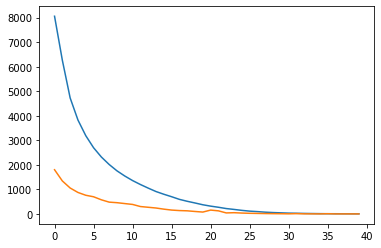

In [30]:
plt.plot(train_losses_adam)
plt.plot(val_losses_adam)
plt.show()

ADAM is a combination of SGD with momentum method + RMSprop. ADAM tries to take into account the previous gradient steps of the algorithm. In our case, SGD decreased the loss faster, but ADAM was less stochastic (as expected). However, we can not state that one of them outperformed the other because their results look similar and each may perform better with different learning rates.

In [43]:
class DropoutModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)
        self.l5 = nn.Linear(64, 32)
        self.l6 = nn.Linear(32, 26)

        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.loss = nn.CrossEntropyLoss(reduction='mean')
    

    def forward(self, xb, yb=None):
        xb = self.dropout(self.act(self.l1(xb)))
        xb = self.dropout(self.act(self.l2(xb)))
        xb = self.dropout(self.act(self.l3(xb)))
        xb = self.dropout(self.act(self.l4(xb)))
        xb = self.act(self.l5(xb))
        logits = self.l6(xb)

        if not yb is None:
            loss = self.loss(logits, yb)
        else:
            loss = None
        return logits, loss

In [32]:
model_dropout = DropoutModel().to(device)
optimizer_sgd = SGD(model_dropout.parameters(), lr=0.001)
train_losses_dropout, val_losses_dropout = train_model(model_dropout, train_dataloader, val_dataloader, optimizer_sgd, epochs=150)

------------------------------ epoch:  0


100%|██████████| 2746/2746 [00:11<00:00, 228.84it/s]


train loss: 8935.804819583893


100%|██████████| 687/687 [00:00<00:00, 911.98it/s]


val accuracy:  0.06079196876742889
val loss: 2170.7687764167786
------------------------------ epoch:  1


100%|██████████| 2746/2746 [00:12<00:00, 225.00it/s]


train loss: 8216.47395658493


100%|██████████| 687/687 [00:00<00:00, 897.89it/s]


val accuracy:  0.11335750139431121
val loss: 1951.2744896411896
------------------------------ epoch:  2


100%|██████████| 2746/2746 [00:11<00:00, 229.62it/s]


train loss: 7162.167678952217


100%|██████████| 687/687 [00:00<00:00, 870.08it/s]


val accuracy:  0.16480758505298382
val loss: 1700.3997386693954
------------------------------ epoch:  3


100%|██████████| 2746/2746 [00:12<00:00, 223.29it/s]


train loss: 6329.278355121613


100%|██████████| 687/687 [00:00<00:00, 911.13it/s]


val accuracy:  0.21514221974344674
val loss: 1529.7964646816254
------------------------------ epoch:  4


100%|██████████| 2746/2746 [00:12<00:00, 220.52it/s]


train loss: 5759.042790412903


100%|██████████| 687/687 [00:00<00:00, 907.66it/s]


val accuracy:  0.2551589514779699
val loss: 1396.7249414920807
------------------------------ epoch:  5


100%|██████████| 2746/2746 [00:12<00:00, 224.83it/s]


train loss: 5320.155069291592


100%|██████████| 687/687 [00:00<00:00, 899.83it/s]


val accuracy:  0.29517568321249305
val loss: 1282.6902968287468
------------------------------ epoch:  6


100%|██████████| 2746/2746 [00:12<00:00, 221.21it/s]


train loss: 4953.041168630123


100%|██████████| 687/687 [00:00<00:00, 924.77it/s]


val accuracy:  0.32431678750697157
val loss: 1191.693207859993
------------------------------ epoch:  7


100%|██████████| 2746/2746 [00:12<00:00, 224.77it/s]


train loss: 4610.264798879623


100%|██████████| 687/687 [00:00<00:00, 914.39it/s]


val accuracy:  0.34453430005577246
val loss: 1132.9522666931152
------------------------------ epoch:  8


100%|██████████| 2746/2746 [00:12<00:00, 220.89it/s]


train loss: 4310.233035981655


100%|██████████| 687/687 [00:00<00:00, 889.95it/s]


val accuracy:  0.3622420524261015
val loss: 1067.2665075957775
------------------------------ epoch:  9


100%|██████████| 2746/2746 [00:12<00:00, 222.60it/s]


train loss: 4080.12136682868


100%|██████████| 687/687 [00:00<00:00, 906.24it/s]


val accuracy:  0.3930563301728946
val loss: 987.9048110842705
------------------------------ epoch:  10


100%|██████████| 2746/2746 [00:12<00:00, 226.26it/s]


train loss: 3833.2721969783306


100%|██████████| 687/687 [00:00<00:00, 899.15it/s]


val accuracy:  0.39347462353597323
val loss: 988.5322820842266
------------------------------ epoch:  11


100%|██████████| 2746/2746 [00:12<00:00, 224.11it/s]


train loss: 3607.537010550499


100%|██████████| 687/687 [00:00<00:00, 897.05it/s]


val accuracy:  0.42889012827663137
val loss: 883.641062527895
------------------------------ epoch:  12


100%|██████████| 2746/2746 [00:12<00:00, 220.03it/s]


train loss: 3408.8412906229496


100%|██████████| 687/687 [00:00<00:00, 895.31it/s]


val accuracy:  0.4262409369771333
val loss: 860.0861508995295
------------------------------ epoch:  13


100%|██████████| 2746/2746 [00:13<00:00, 206.80it/s]


train loss: 3222.953243330121


100%|██████████| 687/687 [00:00<00:00, 893.91it/s]


val accuracy:  0.46235359732292247
val loss: 792.0255241543055
------------------------------ epoch:  14


100%|██████████| 2746/2746 [00:12<00:00, 220.96it/s]


train loss: 3052.8982420116663


100%|██████████| 687/687 [00:00<00:00, 886.38it/s]


val accuracy:  0.478388176240937
val loss: 767.0211191624403
------------------------------ epoch:  15


100%|██████████| 2746/2746 [00:12<00:00, 215.85it/s]


train loss: 2897.285570859909


100%|██████████| 687/687 [00:00<00:00, 897.08it/s]


val accuracy:  0.47671500278862244
val loss: 743.6707126125693
------------------------------ epoch:  16


100%|██████████| 2746/2746 [00:12<00:00, 215.51it/s]


train loss: 2770.673546463251


100%|██████████| 687/687 [00:00<00:00, 880.40it/s]


val accuracy:  0.49930284439486894
val loss: 681.1611238270998
------------------------------ epoch:  17


100%|██████████| 2746/2746 [00:13<00:00, 202.22it/s]


train loss: 2629.434235200286


100%|██████████| 687/687 [00:00<00:00, 874.58it/s]


val accuracy:  0.5118516452872282
val loss: 653.537345379591
------------------------------ epoch:  18


100%|██████████| 2746/2746 [00:12<00:00, 215.54it/s]


train loss: 2481.9201113954186


100%|██████████| 687/687 [00:00<00:00, 897.36it/s]


val accuracy:  0.5151979921918572
val loss: 649.8281649053097
------------------------------ epoch:  19


100%|██████████| 2746/2746 [00:12<00:00, 215.60it/s]


train loss: 2397.0170697905123


100%|██████████| 687/687 [00:00<00:00, 872.39it/s]


val accuracy:  0.5447573898494144
val loss: 577.1047151982784
------------------------------ epoch:  20


100%|██████████| 2746/2746 [00:12<00:00, 213.17it/s]


train loss: 2272.32539511472


100%|██████████| 687/687 [00:00<00:00, 856.84it/s]


val accuracy:  0.5497769102063581
val loss: 551.4120047464967
------------------------------ epoch:  21


100%|██████████| 2746/2746 [00:12<00:00, 216.10it/s]


train loss: 2165.9754947423935


100%|██████████| 687/687 [00:00<00:00, 878.00it/s]


val accuracy:  0.5561907417735639
val loss: 535.8236336037517
------------------------------ epoch:  22


100%|██████████| 2746/2746 [00:13<00:00, 210.65it/s]


train loss: 2058.061263669282


100%|██████████| 687/687 [00:00<00:00, 882.67it/s]


val accuracy:  0.5588399330730619
val loss: 513.7605379000306
------------------------------ epoch:  23


100%|██████████| 2746/2746 [00:12<00:00, 213.29it/s]


train loss: 1977.6812206879258


100%|██████████| 687/687 [00:00<00:00, 846.00it/s]


val accuracy:  0.5670663692136084
val loss: 509.8622153401375
------------------------------ epoch:  24


100%|██████████| 2746/2746 [00:12<00:00, 218.41it/s]


train loss: 1872.406107602641


100%|██████████| 687/687 [00:00<00:00, 860.99it/s]


val accuracy:  0.5808700501952035
val loss: 463.5358944647014
------------------------------ epoch:  25


100%|██████████| 2746/2746 [00:12<00:00, 214.61it/s]


train loss: 1814.9050409365445


100%|██████████| 687/687 [00:00<00:00, 849.53it/s]


val accuracy:  0.5939765755716676
val loss: 446.1790387071669
------------------------------ epoch:  26


100%|██████████| 2746/2746 [00:13<00:00, 208.27it/s]


train loss: 1744.0190009400249


100%|██████████| 687/687 [00:00<00:00, 845.73it/s]


val accuracy:  0.5963469046291132
val loss: 425.0606592986733
------------------------------ epoch:  27


100%|██████████| 2746/2746 [00:12<00:00, 214.80it/s]


train loss: 1644.189870281145


100%|██████████| 687/687 [00:00<00:00, 879.39it/s]


val accuracy:  0.6022030117122141
val loss: 413.8432521894574
------------------------------ epoch:  28


100%|██████████| 2746/2746 [00:13<00:00, 207.72it/s]


train loss: 1565.5595995858312


100%|██████████| 687/687 [00:00<00:00, 875.05it/s]


val accuracy:  0.6137757947573899
val loss: 401.4522619098425
------------------------------ epoch:  29


100%|██████████| 2746/2746 [00:12<00:00, 217.49it/s]


train loss: 1508.916265499778


100%|██████████| 687/687 [00:00<00:00, 890.31it/s]


val accuracy:  0.6200501952035694
val loss: 376.16043561697006
------------------------------ epoch:  30


100%|██████████| 2746/2746 [00:12<00:00, 218.39it/s]


train loss: 1449.4796618907712


100%|██████████| 687/687 [00:00<00:00, 858.53it/s]


val accuracy:  0.6180981595092024
val loss: 378.3496958985925
------------------------------ epoch:  31


100%|██████████| 2746/2746 [00:12<00:00, 218.50it/s]


train loss: 1381.6760411602445


100%|██████████| 687/687 [00:00<00:00, 889.49it/s]


val accuracy:  0.6360847741215839
val loss: 326.7849069079384
------------------------------ epoch:  32


100%|██████████| 2746/2746 [00:12<00:00, 222.33it/s]


train loss: 1313.9404092542827


100%|██████████| 687/687 [00:00<00:00, 860.60it/s]


val accuracy:  0.6373396542108198
val loss: 341.50355612672865
------------------------------ epoch:  33


100%|██████████| 2746/2746 [00:12<00:00, 216.83it/s]


train loss: 1264.463723020628


100%|██████████| 687/687 [00:00<00:00, 867.14it/s]


val accuracy:  0.6423591745677635
val loss: 324.9109807088971
------------------------------ epoch:  34


100%|██████████| 2746/2746 [00:12<00:00, 212.61it/s]


train loss: 1210.1484034687746


100%|██████████| 687/687 [00:00<00:00, 838.90it/s]


val accuracy:  0.6500278862242053
val loss: 301.7966898176819
------------------------------ epoch:  35


100%|██████████| 2746/2746 [00:13<00:00, 210.07it/s]


train loss: 1174.9153286665678


100%|██████████| 687/687 [00:00<00:00, 863.51it/s]


val accuracy:  0.6523982152816509
val loss: 298.535626264289
------------------------------ epoch:  36


100%|██████████| 2746/2746 [00:12<00:00, 216.03it/s]


train loss: 1113.171721256338


100%|██████████| 687/687 [00:00<00:00, 855.77it/s]


val accuracy:  0.6535136642498606
val loss: 281.9035697430372
------------------------------ epoch:  37


100%|██████████| 2746/2746 [00:13<00:00, 208.04it/s]


train loss: 1077.4188309484161


100%|██████████| 687/687 [00:00<00:00, 880.87it/s]


val accuracy:  0.6544896820970441
val loss: 292.8806858723983
------------------------------ epoch:  38


100%|██████████| 2746/2746 [00:12<00:00, 217.49it/s]


train loss: 1030.495183696039


100%|██████████| 687/687 [00:00<00:00, 862.89it/s]


val accuracy:  0.6597880646960401
val loss: 273.99321783310734
------------------------------ epoch:  39


100%|██████████| 2746/2746 [00:15<00:00, 173.66it/s]


train loss: 987.1512370142736


100%|██████████| 687/687 [00:00<00:00, 917.70it/s]


val accuracy:  0.6741494701617401
val loss: 240.92725486960262
------------------------------ epoch:  40


100%|██████████| 2746/2746 [00:13<00:00, 199.06it/s]


train loss: 961.9649324393831


100%|██████████| 687/687 [00:00<00:00, 728.44it/s]


val accuracy:  0.6730340211935304
val loss: 245.9201846444048
------------------------------ epoch:  41


100%|██████████| 2746/2746 [00:16<00:00, 162.37it/s]


train loss: 911.0484264232218


100%|██████████| 687/687 [00:00<00:00, 890.31it/s]


val accuracy:  0.6588120468488566
val loss: 281.58694122126326
------------------------------ epoch:  42


100%|██████████| 2746/2746 [00:13<00:00, 206.24it/s]


train loss: 898.654209726461


100%|██████████| 687/687 [00:01<00:00, 663.91it/s]


val accuracy:  0.6783324037925265
val loss: 223.16039217845537
------------------------------ epoch:  43


100%|██████████| 2746/2746 [00:17<00:00, 156.73it/s]


train loss: 855.20715764747


100%|██████████| 687/687 [00:00<00:00, 873.37it/s]


val accuracy:  0.682654768544339
val loss: 213.53729404322803
------------------------------ epoch:  44


100%|██████████| 2746/2746 [00:16<00:00, 168.08it/s]


train loss: 823.0535127740586


100%|██████████| 687/687 [00:01<00:00, 641.83it/s]


val accuracy:  0.6812604573340769
val loss: 224.1053457990056
------------------------------ epoch:  45


100%|██████████| 2746/2746 [00:15<00:00, 177.03it/s]


train loss: 797.0987298797118


100%|██████████| 687/687 [00:00<00:00, 876.96it/s]


val accuracy:  0.6887897378694925
val loss: 201.4023383629392
------------------------------ epoch:  46


100%|██████████| 2746/2746 [00:12<00:00, 216.76it/s]


train loss: 759.2110531814396


100%|██████████| 687/687 [00:00<00:00, 889.51it/s]


val accuracy:  0.6869771332961517
val loss: 201.09289393108338
------------------------------ epoch:  47


100%|██████████| 2746/2746 [00:16<00:00, 170.66it/s]


train loss: 740.5947352235671


100%|██████████| 687/687 [00:00<00:00, 717.53it/s]


val accuracy:  0.6932515337423313
val loss: 199.81900516839232
------------------------------ epoch:  48


100%|██████████| 2746/2746 [00:15<00:00, 179.03it/s]


train loss: 693.3295788360992


100%|██████████| 687/687 [00:00<00:00, 880.17it/s]


val accuracy:  0.6906023424428333
val loss: 202.45162355795037
------------------------------ epoch:  49


100%|██████████| 2746/2746 [00:14<00:00, 190.33it/s]


train loss: 695.6454217915016


100%|██████████| 687/687 [00:00<00:00, 910.47it/s]


val accuracy:  0.6857222532069158
val loss: 211.959005345474
------------------------------ epoch:  50


100%|██████████| 2746/2746 [00:13<00:00, 197.02it/s]


train loss: 657.3957492983609


100%|██████████| 687/687 [00:01<00:00, 660.33it/s]


val accuracy:  0.6993865030674846
val loss: 173.93346786826442
------------------------------ epoch:  51


100%|██████████| 2746/2746 [00:20<00:00, 136.76it/s]


train loss: 662.7965209198737


100%|██████████| 687/687 [00:01<00:00, 657.88it/s]


val accuracy:  0.702175125488009
val loss: 168.4017875691643
------------------------------ epoch:  52


100%|██████████| 2746/2746 [00:15<00:00, 179.67it/s]


train loss: 600.8732692598714


100%|██████████| 687/687 [00:00<00:00, 860.06it/s]


val accuracy:  0.699665365309537
val loss: 171.03797468697303
------------------------------ epoch:  53


100%|██████████| 2746/2746 [00:13<00:00, 210.00it/s]


train loss: 613.729681557088


100%|██████████| 687/687 [00:00<00:00, 855.50it/s]


val accuracy:  0.7126324595649749
val loss: 143.79470572434366
------------------------------ epoch:  54


100%|██████████| 2746/2746 [00:13<00:00, 207.10it/s]


train loss: 594.2320348801368


100%|██████████| 687/687 [00:00<00:00, 824.24it/s]


val accuracy:  0.7035694366982711
val loss: 168.3229573961653
------------------------------ epoch:  55


100%|██████████| 2746/2746 [00:14<00:00, 193.65it/s]


train loss: 567.3502506879377


100%|██████████| 687/687 [00:00<00:00, 830.66it/s]


val accuracy:  0.71207473508087
val loss: 141.16401249391492
------------------------------ epoch:  56


100%|██████████| 2746/2746 [00:13<00:00, 199.40it/s]


train loss: 546.498800620273


100%|██████████| 687/687 [00:00<00:00, 833.05it/s]


val accuracy:  0.7080312325711099
val loss: 158.3179413122416
------------------------------ epoch:  57


100%|██████████| 2746/2746 [00:13<00:00, 207.00it/s]


train loss: 536.3092645328143


100%|██████████| 687/687 [00:00<00:00, 842.83it/s]


val accuracy:  0.7141662018962632
val loss: 131.65821987611707
------------------------------ epoch:  58


100%|██████████| 2746/2746 [00:13<00:00, 199.62it/s]


train loss: 508.3893935416927


100%|██████████| 687/687 [00:00<00:00, 846.79it/s]


val accuracy:  0.7053820412716119
val loss: 171.0217429395707
------------------------------ epoch:  59


100%|██████████| 2746/2746 [00:13<00:00, 196.95it/s]


train loss: 502.34951144750084


100%|██████████| 687/687 [00:00<00:00, 777.63it/s]


val accuracy:  0.7198828778583379
val loss: 120.88198932259729
------------------------------ epoch:  60


100%|██████████| 2746/2746 [00:14<00:00, 186.21it/s]


train loss: 494.19134160429167


100%|██████████| 687/687 [00:00<00:00, 800.54it/s]


val accuracy:  0.7226715002788623
val loss: 115.26565689359268
------------------------------ epoch:  61


100%|██████████| 2746/2746 [00:13<00:00, 197.69it/s]


train loss: 481.0225948265779


100%|██████████| 687/687 [00:00<00:00, 828.36it/s]


val accuracy:  0.7246235359732293
val loss: 107.56382071151165
------------------------------ epoch:  62


100%|██████████| 2746/2746 [00:13<00:00, 204.80it/s]


train loss: 457.1279426057954


100%|██████████| 687/687 [00:00<00:00, 851.75it/s]


val accuracy:  0.7147239263803681
val loss: 138.49161430101958
------------------------------ epoch:  63


100%|██████████| 2746/2746 [00:13<00:00, 207.07it/s]


train loss: 445.7457266360907


100%|██████████| 687/687 [00:00<00:00, 856.72it/s]


val accuracy:  0.7250418293363079
val loss: 109.99904351308214
------------------------------ epoch:  64


100%|██████████| 2746/2746 [00:13<00:00, 201.12it/s]


train loss: 443.69755765071386


100%|██████████| 687/687 [00:00<00:00, 828.88it/s]


val accuracy:  0.721834913552705
val loss: 120.59095167906344
------------------------------ epoch:  65


100%|██████████| 2746/2746 [00:13<00:00, 201.73it/s]


train loss: 424.83943634813795


100%|██████████| 687/687 [00:00<00:00, 835.43it/s]


val accuracy:  0.7212771890686002
val loss: 127.6707578999958
------------------------------ epoch:  66


100%|██████████| 2746/2746 [00:13<00:00, 206.13it/s]


train loss: 419.60129856776257


100%|██████████| 687/687 [00:00<00:00, 845.47it/s]


val accuracy:  0.7240658114891244
val loss: 115.42593583263442
------------------------------ epoch:  67


100%|██████████| 2746/2746 [00:13<00:00, 207.09it/s]


train loss: 409.9240197138279


100%|██████████| 687/687 [00:00<00:00, 856.78it/s]


val accuracy:  0.7315950920245399
val loss: 95.54253164260808
------------------------------ epoch:  68


100%|██████████| 2746/2746 [00:13<00:00, 207.92it/s]


train loss: 389.92233686939744


100%|██████████| 687/687 [00:00<00:00, 831.51it/s]


val accuracy:  0.7313162297824874
val loss: 93.43365763534166
------------------------------ epoch:  69


100%|██████████| 2746/2746 [00:14<00:00, 190.97it/s]


train loss: 387.1779170308023


100%|██████████| 687/687 [00:00<00:00, 811.17it/s]


val accuracy:  0.7190462911321807
val loss: 126.0522732156669
------------------------------ epoch:  70


100%|██████████| 2746/2746 [00:13<00:00, 203.88it/s]


train loss: 372.2411855782984


100%|██████████| 687/687 [00:00<00:00, 872.64it/s]


val accuracy:  0.7289459007250418
val loss: 108.48194880294614
------------------------------ epoch:  71


100%|██████████| 2746/2746 [00:13<00:00, 207.70it/s]


train loss: 368.32753745862146


100%|██████████| 687/687 [00:00<00:00, 887.90it/s]


val accuracy:  0.728388176240937
val loss: 102.7224924377224
------------------------------ epoch:  72


100%|██████████| 2746/2746 [00:12<00:00, 212.56it/s]


train loss: 340.24031886519606


100%|██████████| 687/687 [00:00<00:00, 874.21it/s]


val accuracy:  0.7371723368655884
val loss: 79.54126713637925
------------------------------ epoch:  73


100%|██████████| 2746/2746 [00:12<00:00, 216.22it/s]


train loss: 339.030229007461


100%|██████████| 687/687 [00:00<00:00, 877.52it/s]


val accuracy:  0.7366146123814835
val loss: 77.56246805690034
------------------------------ epoch:  74


100%|██████████| 2746/2746 [00:12<00:00, 217.45it/s]


train loss: 338.7091983502876


100%|██████████| 687/687 [00:00<00:00, 868.56it/s]


val accuracy:  0.7345231455660903
val loss: 83.20910503910773
------------------------------ epoch:  75


100%|██████████| 2746/2746 [00:12<00:00, 213.75it/s]


train loss: 313.666773346637


100%|██████████| 687/687 [00:00<00:00, 874.61it/s]


val accuracy:  0.7367540435025097
val loss: 75.25374607318463
------------------------------ epoch:  76


100%|██████████| 2746/2746 [00:12<00:00, 220.27it/s]


train loss: 306.06589557374264


100%|██████████| 687/687 [00:00<00:00, 872.85it/s]


val accuracy:  0.7401003904071388
val loss: 68.97053767749594
------------------------------ epoch:  77


100%|██████████| 2746/2746 [00:12<00:00, 215.49it/s]


train loss: 302.0164788354384


100%|██████████| 687/687 [00:00<00:00, 876.50it/s]


val accuracy:  0.7352203011712214
val loss: 89.54767709502266
------------------------------ epoch:  78


100%|██████████| 2746/2746 [00:12<00:00, 215.29it/s]


train loss: 293.616724218695


100%|██████████| 687/687 [00:00<00:00, 872.72it/s]


val accuracy:  0.7359174567763525
val loss: 88.8185536115293
------------------------------ epoch:  79


100%|██████████| 2746/2746 [00:13<00:00, 210.58it/s]


train loss: 314.14889212863386


100%|██████████| 687/687 [00:00<00:00, 855.24it/s]


val accuracy:  0.7363357501394311
val loss: 81.37013716323008
------------------------------ epoch:  80


100%|██████████| 2746/2746 [00:12<00:00, 217.81it/s]


train loss: 292.04697945211296


100%|██████████| 687/687 [00:00<00:00, 887.79it/s]


val accuracy:  0.741494701617401
val loss: 70.19843981670192
------------------------------ epoch:  81


100%|██████████| 2746/2746 [00:12<00:00, 215.77it/s]


train loss: 283.34459620445114


100%|██████████| 687/687 [00:00<00:00, 857.47it/s]


val accuracy:  0.7392638036809815
val loss: 77.48121405469601
------------------------------ epoch:  82


100%|██████████| 2746/2746 [00:13<00:00, 208.11it/s]


train loss: 270.04488364117276


100%|██████████| 687/687 [00:00<00:00, 863.85it/s]


val accuracy:  0.7381483547127718
val loss: 74.23612524410419
------------------------------ epoch:  83


100%|██████████| 2746/2746 [00:13<00:00, 200.74it/s]


train loss: 258.0638948613355


100%|██████████| 687/687 [00:00<00:00, 870.54it/s]


val accuracy:  0.7401003904071388
val loss: 72.48040038982163
------------------------------ epoch:  84


100%|██████████| 2746/2746 [00:12<00:00, 212.27it/s]


train loss: 262.63966815455564


100%|██████████| 687/687 [00:00<00:00, 898.42it/s]


val accuracy:  0.7412158393753486
val loss: 68.54789844094807
------------------------------ epoch:  85


100%|██████████| 2746/2746 [00:12<00:00, 216.79it/s]


train loss: 263.231090061234


100%|██████████| 687/687 [00:00<00:00, 889.33it/s]


val accuracy:  0.7444227551589515
val loss: 57.385726214002716
------------------------------ epoch:  86


100%|██████████| 2746/2746 [00:12<00:00, 215.49it/s]


train loss: 253.66755022870885


100%|██████████| 687/687 [00:00<00:00, 845.61it/s]


val accuracy:  0.7462353597322923
val loss: 58.928090727742074
------------------------------ epoch:  87


100%|██████████| 2746/2746 [00:12<00:00, 218.39it/s]


train loss: 251.88356964621943


100%|██████████| 687/687 [00:00<00:00, 882.57it/s]


val accuracy:  0.7426101505856108
val loss: 64.4014307630166
------------------------------ epoch:  88


100%|██████████| 2746/2746 [00:12<00:00, 218.01it/s]


train loss: 224.375078158492


100%|██████████| 687/687 [00:00<00:00, 882.51it/s]


val accuracy:  0.7451199107640826
val loss: 56.79377425530265
------------------------------ epoch:  89


100%|██████████| 2746/2746 [00:12<00:00, 218.68it/s]


train loss: 247.60860961897242


100%|██████████| 687/687 [00:00<00:00, 887.79it/s]


val accuracy:  0.7424707194645845
val loss: 65.78177314331458
------------------------------ epoch:  90


100%|██████████| 2746/2746 [00:12<00:00, 219.11it/s]


train loss: 225.82204571997806


100%|██████████| 687/687 [00:00<00:00, 869.35it/s]


val accuracy:  0.7389849414389291
val loss: 74.28858560862773
------------------------------ epoch:  91


100%|██████████| 2746/2746 [00:12<00:00, 216.98it/s]


train loss: 233.3535779382878


100%|██████████| 687/687 [00:00<00:00, 893.62it/s]


val accuracy:  0.7456776352481874
val loss: 62.27821845072526
------------------------------ epoch:  92


100%|██████████| 2746/2746 [00:12<00:00, 218.12it/s]


train loss: 219.4993157374542


100%|██████████| 687/687 [00:00<00:00, 888.18it/s]


val accuracy:  0.7466536530953709
val loss: 55.5434994839577
------------------------------ epoch:  93


100%|██████████| 2746/2746 [00:12<00:00, 221.76it/s]


train loss: 222.5683178753258


100%|██████████| 687/687 [00:00<00:00, 864.53it/s]


val accuracy:  0.7470719464584495
val loss: 59.02969829932134
------------------------------ epoch:  94


100%|██████████| 2746/2746 [00:12<00:00, 221.88it/s]


train loss: 201.9313242523147


100%|██████████| 687/687 [00:00<00:00, 858.05it/s]


val accuracy:  0.7476296709425544
val loss: 55.080461747579136
------------------------------ epoch:  95


100%|██████████| 2746/2746 [00:12<00:00, 217.62it/s]


train loss: 190.5283492932387


100%|██████████| 687/687 [00:00<00:00, 848.96it/s]


val accuracy:  0.7430284439486894
val loss: 67.99229160879213
------------------------------ epoch:  96


100%|██████████| 2746/2746 [00:12<00:00, 215.43it/s]


train loss: 203.60734126055144


100%|██████████| 687/687 [00:00<00:00, 854.43it/s]


val accuracy:  0.7469325153374233
val loss: 53.56702183165771
------------------------------ epoch:  97


100%|██████████| 2746/2746 [00:12<00:00, 215.67it/s]


train loss: 202.1436246991638


100%|██████████| 687/687 [00:00<00:00, 852.99it/s]


val accuracy:  0.7488845510317903
val loss: 48.725801727662926
------------------------------ epoch:  98


100%|██████████| 2746/2746 [00:13<00:00, 203.66it/s]


train loss: 200.4162217391864


100%|██████████| 687/687 [00:00<00:00, 845.80it/s]


val accuracy:  0.75
val loss: 52.609269936538794
------------------------------ epoch:  99


100%|██████████| 2746/2746 [00:13<00:00, 202.33it/s]


train loss: 198.94135977691639


100%|██████████| 687/687 [00:00<00:00, 814.03it/s]


val accuracy:  0.7335471277189068
val loss: 106.6420995754604
------------------------------ epoch:  100


100%|██████████| 2746/2746 [00:13<00:00, 206.86it/s]


train loss: 181.2958640459852


100%|██████████| 687/687 [00:00<00:00, 873.37it/s]


val accuracy:  0.7479085331846068
val loss: 49.747515754222036
------------------------------ epoch:  101


100%|██████████| 2746/2746 [00:13<00:00, 205.24it/s]


train loss: 188.93015314743965


100%|██████████| 687/687 [00:00<00:00, 820.69it/s]


val accuracy:  0.7486056887897379
val loss: 48.91117821372313
------------------------------ epoch:  102


100%|██████████| 2746/2746 [00:13<00:00, 202.27it/s]


train loss: 185.54299661805337


100%|██████████| 687/687 [00:00<00:00, 843.22it/s]


val accuracy:  0.7486056887897379
val loss: 50.71058121659675
------------------------------ epoch:  103


100%|██████████| 2746/2746 [00:13<00:00, 207.46it/s]


train loss: 180.72315932264


100%|██████████| 687/687 [00:00<00:00, 862.99it/s]


val accuracy:  0.7505577244841048
val loss: 41.31894098077973
------------------------------ epoch:  104


100%|██████████| 2746/2746 [00:12<00:00, 212.89it/s]


train loss: 195.14904302119487


100%|██████████| 687/687 [00:00<00:00, 877.60it/s]


val accuracy:  0.7504182933630786
val loss: 41.3384446321236
------------------------------ epoch:  105


100%|██████████| 2746/2746 [00:12<00:00, 215.03it/s]


train loss: 160.14064206182965


100%|██████████| 687/687 [00:00<00:00, 862.05it/s]


val accuracy:  0.7420524261015059
val loss: 70.73691254024351
------------------------------ epoch:  106


100%|██████████| 2746/2746 [00:12<00:00, 217.80it/s]


train loss: 167.1655028640836


100%|██████████| 687/687 [00:00<00:00, 839.49it/s]


val accuracy:  0.7497211377579476
val loss: 47.35599219932979
------------------------------ epoch:  107


100%|██████████| 2746/2746 [00:12<00:00, 215.57it/s]


train loss: 169.211685599489


100%|██████████| 687/687 [00:00<00:00, 852.41it/s]


val accuracy:  0.7487451199107641
val loss: 51.58435602645122
------------------------------ epoch:  108


100%|██████████| 2746/2746 [00:12<00:00, 213.10it/s]


train loss: 168.77561604996504


100%|██████████| 687/687 [00:00<00:00, 843.71it/s]


val accuracy:  0.7509760178471835
val loss: 43.736234885558105
------------------------------ epoch:  109


100%|██████████| 2746/2746 [00:12<00:00, 212.47it/s]


train loss: 175.98679336654212


100%|██████████| 687/687 [00:00<00:00, 856.80it/s]


val accuracy:  0.75
val loss: 42.67916463698643
------------------------------ epoch:  110


100%|██████████| 2746/2746 [00:12<00:00, 213.51it/s]


train loss: 163.94049004885903


100%|██████████| 687/687 [00:00<00:00, 865.47it/s]


val accuracy:  0.7493028443948689
val loss: 48.71878291145987
------------------------------ epoch:  111


100%|██████████| 2746/2746 [00:12<00:00, 213.66it/s]


train loss: 156.41171059312086


100%|██████████| 687/687 [00:01<00:00, 587.60it/s]


val accuracy:  0.7525097601784718
val loss: 40.89621812925173
------------------------------ epoch:  112


100%|██████████| 2746/2746 [00:13<00:00, 204.47it/s]


train loss: 146.05977411469615


100%|██████████| 687/687 [00:00<00:00, 874.62it/s]


val accuracy:  0.7504182933630786
val loss: 50.58089276367707
------------------------------ epoch:  113


100%|██████████| 2746/2746 [00:12<00:00, 213.98it/s]


train loss: 151.39338608079981


100%|██████████| 687/687 [00:00<00:00, 889.88it/s]


val accuracy:  0.7518126045733408
val loss: 35.995796316003066
------------------------------ epoch:  114


100%|██████████| 2746/2746 [00:12<00:00, 223.74it/s]


train loss: 147.0051863027171


100%|██████████| 687/687 [00:00<00:00, 863.84it/s]


val accuracy:  0.752649191299498
val loss: 34.91780419443642
------------------------------ epoch:  115


100%|██████████| 2746/2746 [00:12<00:00, 222.16it/s]


train loss: 132.56515103118414


100%|██████████| 687/687 [00:00<00:00, 914.25it/s]


val accuracy:  0.7541829336307864
val loss: 34.27089797419287
------------------------------ epoch:  116


100%|██████████| 2746/2746 [00:12<00:00, 217.69it/s]


train loss: 140.84157458701404


100%|██████████| 687/687 [00:00<00:00, 862.72it/s]


val accuracy:  0.7527886224205242
val loss: 43.991073875028405
------------------------------ epoch:  117


100%|██████████| 2746/2746 [00:12<00:00, 219.09it/s]


train loss: 138.06704386602973


100%|██████████| 687/687 [00:00<00:00, 882.08it/s]


val accuracy:  0.7540435025097602
val loss: 31.05245495113016
------------------------------ epoch:  118


100%|██████████| 2746/2746 [00:12<00:00, 214.46it/s]


train loss: 137.24265228687605


100%|██████████| 687/687 [00:00<00:00, 850.81it/s]


val accuracy:  0.7539040713887339
val loss: 34.1477681245299
------------------------------ epoch:  119


100%|██████████| 2746/2746 [00:13<00:00, 206.72it/s]


train loss: 146.56433898152977


100%|██████████| 687/687 [00:00<00:00, 801.51it/s]


val accuracy:  0.7533463469046291
val loss: 32.24152481633183
------------------------------ epoch:  120


100%|██████████| 2746/2746 [00:12<00:00, 216.47it/s]


train loss: 136.1380461314429


100%|██████████| 687/687 [00:00<00:00, 838.54it/s]


val accuracy:  0.7534857780256553
val loss: 34.197192836810274
------------------------------ epoch:  121


100%|██████████| 2746/2746 [00:12<00:00, 216.40it/s]


train loss: 141.33713696611312


100%|██████████| 687/687 [00:00<00:00, 875.61it/s]


val accuracy:  0.7537646402677077
val loss: 38.68624457897812
------------------------------ epoch:  122


100%|██████████| 2746/2746 [00:12<00:00, 216.51it/s]


train loss: 131.82203523022278


100%|██████████| 687/687 [00:00<00:00, 863.30it/s]


val accuracy:  0.7550195203569436
val loss: 29.356068175637134
------------------------------ epoch:  123


100%|██████████| 2746/2746 [00:12<00:00, 213.99it/s]


train loss: 134.4824034263021


100%|██████████| 687/687 [00:00<00:00, 831.85it/s]


val accuracy:  0.7527886224205242
val loss: 36.83093195293947
------------------------------ epoch:  124


100%|██████████| 2746/2746 [00:12<00:00, 216.46it/s]


train loss: 136.83374239099726


100%|██████████| 687/687 [00:00<00:00, 832.89it/s]


val accuracy:  0.7532069157836029
val loss: 39.4880342128573
------------------------------ epoch:  125


100%|██████████| 2746/2746 [00:12<00:00, 214.26it/s]


train loss: 117.80169486338596


100%|██████████| 687/687 [00:00<00:00, 864.25it/s]


val accuracy:  0.7582264361405465
val loss: 21.34927514660125
------------------------------ epoch:  126


100%|██████████| 2746/2746 [00:12<00:00, 222.67it/s]


train loss: 129.1900142120919


100%|██████████| 687/687 [00:00<00:00, 876.22it/s]


val accuracy:  0.7550195203569436
val loss: 35.40363637260923
------------------------------ epoch:  127


100%|██████████| 2746/2746 [00:13<00:00, 211.11it/s]


train loss: 127.8927041689284


100%|██████████| 687/687 [00:00<00:00, 899.11it/s]


val accuracy:  0.7543223647518126
val loss: 32.009932941766124
------------------------------ epoch:  128


100%|██████████| 2746/2746 [00:12<00:00, 225.35it/s]


train loss: 130.77897414462478


100%|██████████| 687/687 [00:00<00:00, 893.69it/s]


val accuracy:  0.7555772448410485
val loss: 29.359508259973165
------------------------------ epoch:  129


100%|██████████| 2746/2746 [00:12<00:00, 225.98it/s]


train loss: 116.58966026992084


100%|██████████| 687/687 [00:00<00:00, 898.46it/s]


val accuracy:  0.7552983825989961
val loss: 31.114424269907822
------------------------------ epoch:  130


100%|██████████| 2746/2746 [00:12<00:00, 227.40it/s]


train loss: 113.93721887459034


100%|██████████| 687/687 [00:00<00:00, 881.04it/s]


val accuracy:  0.7544617958728388
val loss: 34.13758716409007
------------------------------ epoch:  131


100%|██████████| 2746/2746 [00:12<00:00, 227.18it/s]


train loss: 124.63720993080632


100%|██████████| 687/687 [00:00<00:00, 874.23it/s]


val accuracy:  0.7587841606246514
val loss: 22.323173664074325
------------------------------ epoch:  132


100%|██████████| 2746/2746 [00:12<00:00, 224.11it/s]


train loss: 105.90536906252368


100%|██████████| 687/687 [00:00<00:00, 907.42it/s]


val accuracy:  0.7571109871723368
val loss: 26.039035518234513
------------------------------ epoch:  133


100%|██████████| 2746/2746 [00:11<00:00, 231.49it/s]


train loss: 116.81473921462458


100%|██████████| 687/687 [00:00<00:00, 909.62it/s]


val accuracy:  0.7544617958728388
val loss: 33.62150310985316
------------------------------ epoch:  134


100%|██████████| 2746/2746 [00:11<00:00, 230.78it/s]


train loss: 119.60743141934918


100%|██████████| 687/687 [00:00<00:00, 897.69it/s]


val accuracy:  0.757250418293363
val loss: 28.594588437272794
------------------------------ epoch:  135


100%|██████████| 2746/2746 [00:11<00:00, 230.31it/s]


train loss: 115.40846743711323


100%|██████████| 687/687 [00:00<00:00, 888.83it/s]


val accuracy:  0.7571109871723368
val loss: 29.75981257883417
------------------------------ epoch:  136


100%|██████████| 2746/2746 [00:11<00:00, 231.16it/s]


train loss: 103.20922243878142


100%|██████████| 687/687 [00:00<00:00, 929.62it/s]


val accuracy:  0.7555772448410485
val loss: 29.16817395466576
------------------------------ epoch:  137


100%|██████████| 2746/2746 [00:12<00:00, 226.54it/s]


train loss: 102.81222380085353


100%|██████████| 687/687 [00:00<00:00, 902.54it/s]


val accuracy:  0.7557166759620747
val loss: 29.762791235076406
------------------------------ epoch:  138


100%|██████████| 2746/2746 [00:11<00:00, 232.54it/s]


train loss: 110.82686089408627


100%|██████████| 687/687 [00:00<00:00, 912.38it/s]


val accuracy:  0.7573898494143892
val loss: 25.373674802253273
------------------------------ epoch:  139


100%|██████████| 2746/2746 [00:12<00:00, 226.84it/s]


train loss: 110.21941651304206


100%|██████████| 687/687 [00:00<00:00, 914.98it/s]


val accuracy:  0.7586447295036252
val loss: 20.627693927945565
------------------------------ epoch:  140


100%|██████████| 2746/2746 [00:11<00:00, 228.91it/s]


train loss: 116.90231257708373


100%|██████████| 687/687 [00:00<00:00, 903.48it/s]


val accuracy:  0.7557166759620747
val loss: 33.877413724748045
------------------------------ epoch:  141


100%|██████████| 2746/2746 [00:11<00:00, 232.22it/s]


train loss: 99.88564431802763


100%|██████████| 687/687 [00:00<00:00, 895.05it/s]


val accuracy:  0.7548800892359174
val loss: 32.42297555773254
------------------------------ epoch:  142


100%|██████████| 2746/2746 [00:19<00:00, 143.03it/s]


train loss: 104.26899636623298


100%|██████████| 687/687 [00:00<00:00, 877.39it/s]


val accuracy:  0.7579475738984941
val loss: 23.87361870996242
------------------------------ epoch:  143


100%|██████████| 2746/2746 [00:20<00:00, 132.40it/s]


train loss: 102.69820313089454


100%|██████████| 687/687 [00:00<00:00, 889.80it/s]


val accuracy:  0.7571109871723368
val loss: 28.909793207297586
------------------------------ epoch:  144


100%|██████████| 2746/2746 [00:12<00:00, 226.65it/s]


train loss: 109.3288387693399


100%|██████████| 687/687 [00:00<00:00, 874.91it/s]


val accuracy:  0.7566926938092582
val loss: 25.43923346167025
------------------------------ epoch:  145


100%|██████████| 2746/2746 [00:12<00:00, 216.29it/s]


train loss: 101.73437535603605


100%|██████████| 687/687 [00:00<00:00, 860.83it/s]


val accuracy:  0.7569715560513106
val loss: 25.27731067058921
------------------------------ epoch:  146


100%|██████████| 2746/2746 [00:12<00:00, 214.12it/s]


train loss: 97.80430338827229


100%|██████████| 687/687 [00:00<00:00, 856.58it/s]


val accuracy:  0.7580870050195203
val loss: 22.52452214436935
------------------------------ epoch:  147


100%|██████████| 2746/2746 [00:13<00:00, 205.93it/s]


train loss: 93.91437416967376


100%|██████████| 687/687 [00:00<00:00, 836.19it/s]


val accuracy:  0.7587841606246514
val loss: 19.880450440031403
------------------------------ epoch:  148


100%|██████████| 2746/2746 [00:12<00:00, 216.24it/s]


train loss: 94.34899897629022


100%|██████████| 687/687 [00:00<00:00, 882.70it/s]


val accuracy:  0.7601784718349136
val loss: 17.330081085451678
------------------------------ epoch:  149


100%|██████████| 2746/2746 [00:13<00:00, 207.54it/s]


train loss: 100.67358676328118


100%|██████████| 687/687 [00:00<00:00, 906.00it/s]

val accuracy:  0.7573898494143892
val loss: 23.63127593056725


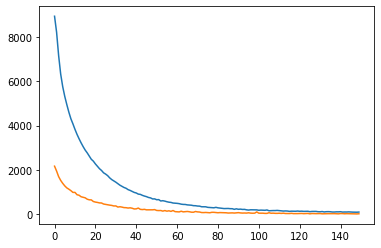

In [33]:
plt.plot(train_losses_dropout)
plt.plot(val_losses_dropout)
plt.show()

In [39]:
evaluate(model_sgd, test_dataloader)
evaluate(model_adam, test_dataloader)
evaluate(model_dropout, test_dataloader)

100%|██████████| 897/897 [00:01<00:00, 701.50it/s]


val accuracy:  0.8177635248187396
val loss: 1312.8324356346443


100%|██████████| 897/897 [00:00<00:00, 1170.28it/s]


val accuracy:  0.7278304517568321
val loss: 1780.1258801527438


100%|██████████| 897/897 [00:00<00:00, 941.50it/s]

val accuracy:  0.7317345231455661
val loss: 2713.5347831186596


(2713.5347831186596, 0.7317345231455661)

Adding dropout didn't help me generalize better (even with p=0.5 or p=0.8). Maybe my network is not deep enough and it needs to be more complex. Overall, my best result was with simple SGD and without dropout (81.7%). 

---------------------------------
real label:  G
predicted label:  G


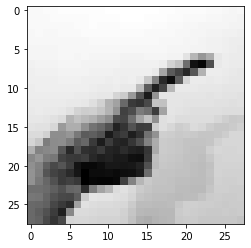

---------------------------------
real label:  C
predicted label:  C


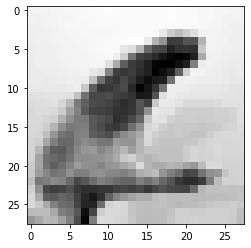

---------------------------------
real label:  V
predicted label:  G


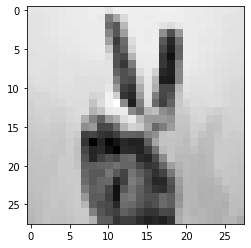

In [58]:
import cv2

for real_label in ['G', 'C', 'V']:
    print('---------------------------------')
    E = cv2.resize(cv2.imread(f'{real_label}.jpg', cv2.IMREAD_GRAYSCALE), (28,28), interpolation = cv2.INTER_AREA)
    x = torch.tensor(E, dtype=torch.float32).reshape((1,-1))
    logits, _ = model_sgd(x, None)
    predicted_label = label_to_char[logits.argmax(dim=1).item()]
    print('real label: ', real_label)
    print('predicted label: ', predicted_label)
    plt.imshow(x.view(28,28), cmap='gray')
    plt.show()

